<a href="https://colab.research.google.com/github/jm12312/Data-Science-And-ML/blob/main/Fashion_Mnist_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

In [ ]:
dataset = FashionMNIST(root='data/', download=True, transform=ToTensor())
test_dataset = FashionMNIST(root='data/', train=False, transform=ToTensor())

In [ ]:
train_ds, val_ds = random_split(dataset, [50000, 10000])
batch_size = 16
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

torch.Size([16, 1, 28, 28]) torch.Size([16])
tensor([4, 2, 8, 3, 9, 5, 7, 9, 2, 1, 9, 1, 8, 1, 9, 9])


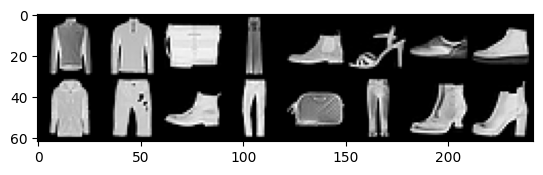

In [ ]:
for img, label in train_loader:
    print(img.shape, label.shape)
    plt.imshow(make_grid(img)[0], cmap='gray')
    print(label)
    break
#

In [ ]:
img.reshape(-1, 784).shape

torch.Size([16, 784])

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class Mnist(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(784, 256)
        self.linear2 = nn.Linear(256, 128)
        self.linear3 = nn.Linear(128, 64)
        self.linear4 = nn.Linear(64, 32)
        self.linear5 = nn.Linear(32, 10)

    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = F.relu(self.linear1(xb))
        out = F.relu(self.linear2(out))
        out = F.relu(self.linear3(out))
        out = F.relu(self.linear4(out))
        out = self.linear5(out)
        return out

    def calculate_loss(self, batch):
        img, label = batch
        op = self(img)
        loss = F.cross_entropy(op, label)
        return loss

    def validation_step(self, batch):
        img, label = batch
        op = self(img)
        loss = F.cross_entropy(op, label)
        acc = accuracy(op, label)
        return {'val_loss': loss, 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print(f'Epoch: {epoch},  Val Loss: {result["val_loss"]}, Val Acc: {result["val_acc"]}')

In [ ]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

device = get_default_device()
device

device(type='cuda')

In [ ]:
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [ ]:
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for batch in self.dl:
            yield to_device(batch, self.device)

    def __len__(self):
        return len(self.dl)

In [ ]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [ ]:
for img, label in train_loader:
    print(img.device)
    break

cuda:0


In [ ]:
def evaluate(model, val_loader):
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

def fit(model, opt, train_dl, loss_fn, epochs, val_loader):
  history = []
  for epoch in range(epochs):
    for img, label in train_dl:
      loss = model.calculate_loss((img, label))
      loss.backward()
      opt.step()
      opt.zero_grad()

    result = evaluate(model, val_loader)

    model.epoch_end(epoch, result)
    history.append(result)
  return history

In [ ]:
model = Mnist()
to_device(model, device)

Mnist(
  (linear1): Linear(in_features=784, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=64, bias=True)
  (linear4): Linear(in_features=64, out_features=32, bias=True)
  (linear5): Linear(in_features=32, out_features=10, bias=True)
)

In [ ]:
hist = fit(model, torch.optim.SGD(model.parameters(), lr=0.3), train_loader, F.cross_entropy, 5, val_loader)

Epoch: 0,  Val Loss: 0.7828390598297119, Val Acc: 0.762499988079071
Epoch: 1,  Val Loss: 0.4667704105377197, Val Acc: 0.8361999988555908
Epoch: 2,  Val Loss: 0.44269275665283203, Val Acc: 0.8398000001907349
Epoch: 3,  Val Loss: 0.4663877785205841, Val Acc: 0.8389000296592712
Epoch: 4,  Val Loss: 0.49337244033813477, Val Acc: 0.8116000294685364


In [ ]:
hist += fit(model, torch.optim.Adam(model.parameters(), lr=1e-4), train_loader, F.cross_entropy, 30, val_loader)

Epoch: 0,  Val Loss: 3.510124921798706, Val Acc: 0.8914999961853027
Epoch: 1,  Val Loss: 3.513031244277954, Val Acc: 0.8924000263214111
Epoch: 2,  Val Loss: 3.587374448776245, Val Acc: 0.8931999802589417
Epoch: 3,  Val Loss: 3.4945690631866455, Val Acc: 0.8913000226020813
Epoch: 4,  Val Loss: 3.636993169784546, Val Acc: 0.8917999863624573
Epoch: 5,  Val Loss: 3.60562801361084, Val Acc: 0.8935999870300293
Epoch: 6,  Val Loss: 3.730884313583374, Val Acc: 0.8909000158309937
Epoch: 7,  Val Loss: 3.624204635620117, Val Acc: 0.8907999992370605
Epoch: 8,  Val Loss: 3.749256134033203, Val Acc: 0.8924000263214111
Epoch: 9,  Val Loss: 3.781187057495117, Val Acc: 0.8919000029563904
Epoch: 10,  Val Loss: 3.695495128631592, Val Acc: 0.8931999802589417
Epoch: 11,  Val Loss: 3.768306255340576, Val Acc: 0.8921999931335449
Epoch: 12,  Val Loss: 3.9281513690948486, Val Acc: 0.8925999999046326
Epoch: 13,  Val Loss: 3.8973441123962402, Val Acc: 0.8914999961853027
Epoch: 14,  Val Loss: 3.945858955383301, V

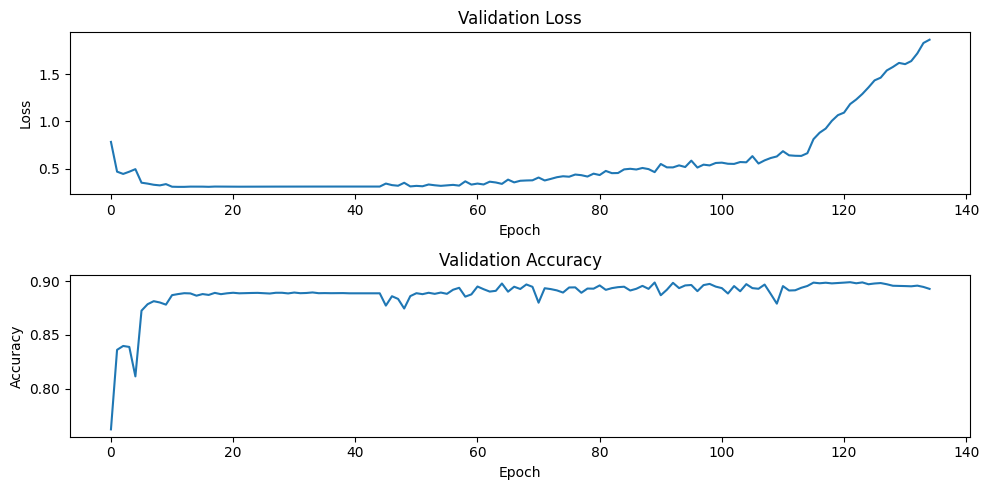

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(10, 5))  # Create a figure and two axes (2 rows, 1 column)

# Plot validation loss
axs[0].plot([x['val_loss'] for x in hist])
axs[0].set_title('Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')

# Plot validation accuracy
axs[1].plot([x['val_acc'] for x in hist])
axs[1].set_title('Validation Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

In [ ]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    op = model(xb)
    _, pred = torch.max(op, dim=1)
    return pred[0].item()

Label: 9 , Predicted: 9


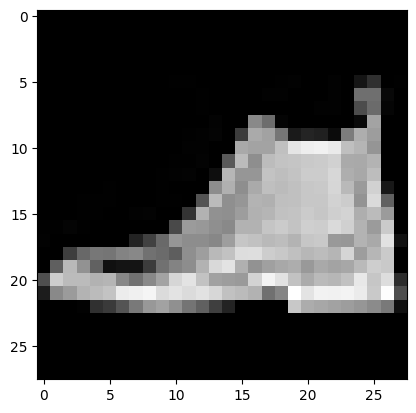

In [ ]:
img, label = test_dataset[1839]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=256)
test_loader = DeviceDataLoader(test_loader, device)
evaluate(model, test_loader)

{'val_loss': 4.799630165100098, 'val_acc': 0.886425793170929}

In [ ]:
torch.save(model.state_dict(), 'mnist-fashion-model.pth')